# How does a Data Scientist buys a house in Amsterdam

I use the DSX, to get an environment for me, and my team, with **Python, Spark, R, Pandas** 

## Step 1 - Load Some houses (Open Data / Public Houses offerings)

In [2]:
!pip install --upgrade sklearn
!pip install xgboost
!pip install geopy
!pip install folium

Requirement already up-to-date: sklearn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages
Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages (from sklearn)


In [3]:
from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_83e2982aad4a45028646908cf6f66a34(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_f2058fa846c0dae077f43f46815b5fbe5b251d9b','domain': {'id': '7391f1fa1cfc4a8d88043ba41bef8e1f'},
            'password': 'i93[Kv#N/l(F)]g.'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_3 = pd.read_csv(get_object_storage_file_with_credentials_83e2982aad4a45028646908cf6f66a34('datacont23', 'amsterdam.csv'), sep=";", usecols=range(13))
df_data_3.head()


postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  
0      5  
1      2  
2      3  
3      2  
4      4

# Vizualize the Data with Folium

In [10]:
import folium

lat_lng_list = list( zip( list(df_data_3.lat), list(df_data_3.lng) ) )
house_density = [ (lat,lng,0.3) for (lat,lng) in lat_lng_list ]
centre_amsterdam = (52.372842, 4.893643)

from folium.plugins import HeatMap

map_with_houses = folium.Map(centre_amsterdam, tiles='cartodbpositron', zoom_start=11)

HeatMap(house_density).add_to(map_with_houses)
map_with_houses

## Step 2 - Feature Engineering, How can we make the columns more useful?

** Latitude / Longiture is only so much information ** How can we make it more interesting ?

![DAM](http://i.imgur.com/zoEWwrn.png)

In [4]:
from geopy.distance import great_circle

def distance_to_Dam_Square(lat, lng):
    DAM_SQUARE = (52.372842, 4.893643)
    return( great_circle( (lat,lng), DAM_SQUARE ).km )

anna_frank = (52.375239, 4.883885)
willems_huis = (51.957744, 4.553619)

print( "The distance (KM) from The Anna Frank house, to the Dam Square is ", distance_to_Dam_Square(*anna_frank) )
print( "The distance (KM) from my house, to the Dam Square is ", distance_to_Dam_Square(*willems_huis) )


The distance (KM) from The Anna Frank house, to the Dam Square is  0.7142338102190251
The distance (KM) from my house, to the Dam Square is  51.66993319639243


In [5]:
# import math

distance_series = df_data_3.apply( lambda x : distance_to_Dam_Square(x.lat , x.lng) , axis=1)
distance_df = distance_series.to_frame(name="distance_to_dam")

In [6]:
with_distance = df_data_3.join( distance_df )

# With the distance to the DAM added, lat/lon have now become usefull features, we did some feature engineering

In [7]:
with_distance.head()

postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  distance_to_dam  
0      5         0.584059  
1      2         1.903278  
2      3         2.372138  
3      2         1.831536  
4      4         6.226566

In [8]:
filterd_on_price = with_distance[ with_distance["price"] > 50000 ]
filterd_on_price.head()

postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  distance_to_dam  
0      5         0.584059  
1      2         1.903278  
2      3         2.372138  
3      2         1.831536  
4      4         6.226566

In [9]:
filtered_on_area = filterd_on_price[filterd_on_price["area"] > 10 ]
filtered_on_area.head()

postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  distance_to_dam  
0      5         0.584059  
1      2         1.903278  
2      3         2.372138  
3      2         1.831536  
4      4         6.226566

In [10]:
filtered_on_type = filtered_on_area[ filtered_on_area["type"] != "garage" ]
filtered_on_type.head()

postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  distance_to_dam  
0      5         0.584059  
1      2         1.903278  
2      3         2.372138  
3      2         1.831536  
4      4         6.226566

# People love high ceilings - If the volume per square meter is high, we have a lot of space above each square meter

## Some more Feature Engineering! If you are good at this, you are a good Data Scientist

The `volume / area` is a indicator for the ceiling height.

![low_ceiling](https://static1.squarespace.com/static/50a3c190e4b0d12fc9231429/t/51412ffbe4b0f9881b974bca/1363226620471/proportion_header.jpg?format=1000w)

In [11]:
volumne_per_square = filtered_on_type.apply( lambda x : (x.volume / (x.area + 1) ) , axis=1)
volumne_per_square_df = volumne_per_square.to_frame(name="volume_per_square")

In [12]:
houses_feature_engineered = filtered_on_type.join( volumne_per_square_df )

In [14]:
houses_feature_engineered.head()


postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden         type  photos  \
0  895000   164     450       4        1700           0     woonhuis      42   
1  275000    56     189       1        1981           0  appartement      27   
2  550000    83     328       1        2000           1  appartement      39   
3  375000    69     222       1        1880           0  appartement      18   
4  249000    97     295       1        2002           0  appartement      22   

   rooms  distance_to_dam  volume_per_square  
0      5         0.584059           2.727273  
1      2         1.903278           3.315789  
2      3         2.372138           3.904762  
3      2         1.831536           3.171429  
4      4         6.226566           3.010204

## Last step - Turn the house type into a number (category)

In [15]:
def house_category( house_type ):
    type = 0
    
    if isinstance( house_type , int):
        return( house_type )
    
    house_type = str(house_type)
    if house_type == "woonhuis":
        return 1
    if house_type == "appartement":
        return 2
    if house_type == "parkeergelegenheid":
        return 3
    return type

In [20]:
houses_feature_engineered["type"].apply( house_category )
houses_feature_engineered["type"] = houses_feature_engineered["type"].apply( house_category )
houses_feature_engineered.head()

postalcode                          street       lat       lng  \
0  1015 AK Amsterdam                  Langestraat 31  52.37799  4.891947   
1  1018 LZ Amsterdam   Kleine Wittenburgerstraat 124  52.37103  4.921513   
2  1073 TB Amsterdam  Karel du Jardinstraat 53 HS+PP  52.35155  4.895647   
3  1073 XA Amsterdam        Gerard Doustraat 190 III  52.35642  4.895630   
4  1067 MT Amsterdam  Jan van Duivenvoordestraat 137  52.37949  4.802591   

    price  area  volume  floors  year_build  has_garden  type  photos  rooms  \
0  895000   164     450       4        1700           0     1      42      5   
1  275000    56     189       1        1981           0     2      27      2   
2  550000    83     328       1        2000           1     2      39      3   
3  375000    69     222       1        1880           0     2      18      2   
4  249000    97     295       1        2002           0     2      22      4   

   distance_to_dam  volume_per_square  
0         0.584059           2.727273  
1         1.903278           3.315789  
2         2.372138           3.904762  
3         1.831536           3.171429  
4         6.226566           3.010204

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Our fist model - Simple Linear Regression with area

In [22]:
# Create linear regression object
regr = LinearRegression(fit_intercept=True)


In [23]:
features = houses_feature_engineered[ houses_feature_engineered.columns[5:6] ]
target = houses_feature_engineered[ ["price"] ]

regr.fit( features, target )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

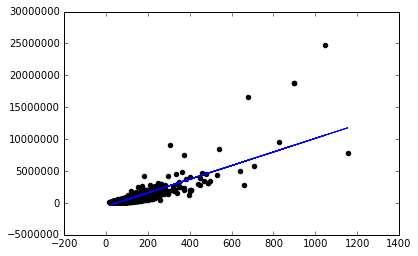

In [25]:
plt.scatter(features, target,  color='black')
plt.plot(features, regr.predict(features), color='blue',         linewidth=1)
plt.ticklabel_format(style='plain', axis='y', )
plt.show()

# What is that weird outlier??! Its Justin Bieber!!!!

Even the best models, cannot predict Justin Bieber

![bieber](http://i.imgur.com/nhFLQZB.png)

In [24]:
"""
Something is 'Quite well Predicted' if the prediction error is 5% or less. 

"""


def percentage_quite_well_predicted( actual_values, predicted_values ):
    actual_values = [ (lambda val: val if val > 0 else 1.0)(val) for val in actual_values ]
    absolute_error = [ abs(val - pred) for (pred,val) in zip(predicted_values, actual_values)]
    relative_differences = [ error/value for (error, value) in zip(absolute_error, actual_values) ]
    treshold = 0.05
    smaller_than_treshold = [ diff < treshold for diff in relative_differences ]
    proportion_within_treshold = sum( smaller_than_treshold ) / len(actual_values)
    return( proportion_within_treshold )

percentage_quite_well_predicted( [100,100,100,100,100], [104,104.4,105.5,99,96])

0.8

In [25]:
preds = regr.predict(features)

In [26]:
percentage_quite_well_predicted(target.price.tolist(),  [ val[0] for val in preds]  )

0.057763211798443258

# Only 6% is well predicted, that is not very much - How can we imporove?

In [27]:
regr.predict(100)

array([[ 522373.9940287]])

In [28]:
all_features = houses_feature_engineered[ houses_feature_engineered.columns[5:] ]
target = houses_feature_engineered[ ["price"] ]

all_features.head()

area  volume  floors  year_build  has_garden  type  photos  rooms  \
0   164     450       4        1700           0     1      42      5   
1    56     189       1        1981           0     2      27      2   
2    83     328       1        2000           1     2      39      3   
3    69     222       1        1880           0     2      18      2   
4    97     295       1        2002           0     2      22      4   

   distance_to_dam  volume_per_square  
0         0.584059           2.727273  
1         1.903278           3.315789  
2         2.372138           3.904762  
3         1.831536           3.171429  
4         6.226566           3.010204

In [29]:
regr_all_features = LinearRegression(fit_intercept=True)
regr_all_features.fit( all_features, target )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
# The coefficients
print('Coefficients: \n', regr_all_features.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr_all_features.predict(all_features) - target) ** 2))

print(regr_all_features.intercept_)

Coefficients: 
 [[  3.37833739e+03   2.55772315e+03  -1.67464273e+04   1.10737632e+01
    8.14652587e+04   3.16699839e+05  -7.18814950e+03  -1.78092075e+04
   -5.43821368e+04  -2.24587338e+05]]
Mean squared error: 302394530132.39
[-83903.15967359]


In [31]:
preds = regr_all_features.predict(all_features)
percentage_quite_well_predicted(target.price.tolist(),  [ val[0] for val in preds]  )

0.077836952068824253

# Even with all features, only 7% was well predicted

### Let's try a more advanced model - a Random Forest

In [32]:
train=houses_feature_engineered.sample(frac=0.8, random_state=2509015)
test=houses_feature_engineered.drop(train.index)

In [33]:
train.head()

postalcode                street       lat       lng   price  \
438   1069 GZ Amsterdam     Ekingenstraat 112  52.35603  4.796796  189000   
2502  1024 BC Amsterdam  Jisperveldstraat 566  52.40040  4.952167  190000   
2453  1019 HG Amsterdam      Zeeburgerkade 34  52.36918  4.940676  375000   
2528  1011 GS Amsterdam  Krom Boomssloot 59 F  52.37104  4.902171  359000   
196   1019 HD Amsterdam  Veembroederhof 121 *  52.37641  4.924291  659000   

      area  volume  floors  year_build  has_garden  type  photos  rooms  \
438     81     240       1        1960           0     2      23      3   
2502    84     260       1        1968           0     2      18      4   
2453    89     306       1        1898           0     2      22      3   
2528    50     140       4        1905           0     2      21      2   
196    146     400       1        2005           0     2      25      4   

      distance_to_dam  volume_per_square  
438          6.838368           2.926829  
2502         5.017879           3.058824  
2453         3.219818           3.400000  
2528         0.612817           2.745098  
196          2.118598           2.721088

# Can we improve, by going to a mode advanced model?

In [34]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=12, n_estimators=100)

target_t = train[ ["price"] ]
all_features_t = train[ houses_feature_engineered.columns[5:] ]

clf.fit(  all_features_t, target_t )

all_features_t.head()

/usr/local/src/conda3_runtime.v12/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


area  volume  floors  year_build  has_garden  type  photos  rooms  \
438     81     240       1        1960           0     2      23      3   
2502    84     260       1        1968           0     2      18      4   
2453    89     306       1        1898           0     2      22      3   
2528    50     140       4        1905           0     2      21      2   
196    146     400       1        2005           0     2      25      4   

      distance_to_dam  volume_per_square  
438          6.838368           2.926829  
2502         5.017879           3.058824  
2453         3.219818           3.400000  
2528         0.612817           2.745098  
196          2.118598           2.721088

In [35]:
test_features =  test[ houses_feature_engineered.columns[5:] ]
test_target = test[ ["price"] ]


preds = clf.predict(test_features)
percentage_quite_well_predicted(test_target.price.tolist(),  [ val for val in preds]  )

0.19057377049180327

# about 20% was well predicted (no fine tuning yet)

In [36]:
feature_imp_dict = {}
for (imp, label) in list( zip( list(clf.feature_importances_), list(all_features.columns) ) ):
    feature_imp_dict[label] = imp

([<matplotlib.axis.XTick at 0x7f927c0342e8>,
 <a list of 10 Text xticklabel objects>)

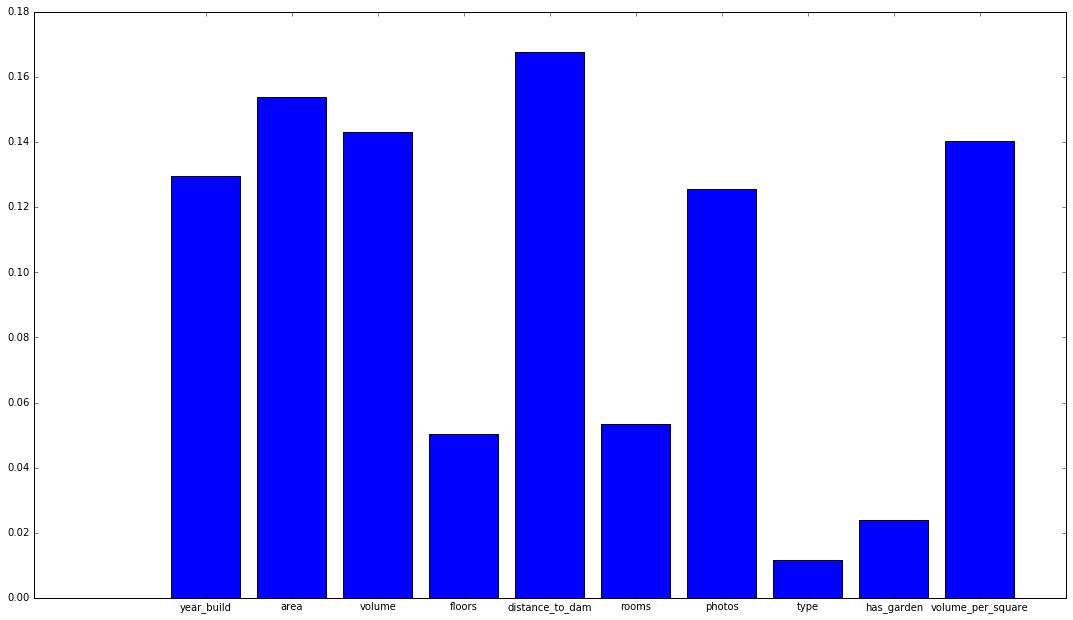

In [37]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

dictionary = plt.figure()
dictionary.set_size_inches(18.5, 10.5)

D = feature_imp_dict

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())


# Secrets I like to share with you
# !!!? Distance to Dam, and Photos are really important for a model!

In [38]:
all_diff =  clf.predict(all_features) - target.price.as_matrix() 
all_diff

array([355000,      0,      0, ...,      0,      0,      0])

# 2 minutes on your bike, is work 65000 euro

In [39]:
[i for i, x in enumerate(all_diff == -2530000) if x]

[]

In [40]:
houses_feature_engineered[1141:1142]

postalcode              street      lat      lng   price  area  \
1250  1019 TR Amsterdam  D.L. Hudigstraat 1  52.3729  4.94108  495000   104   

      volume  floors  year_build  has_garden  type  photos  rooms  \
1250     374       3        1999           0     1      34      4   

      distance_to_dam  volume_per_square  
1250         3.221258           3.561905

In [41]:
clf.predict( all_features[1141:1142] )

array([495000])

# 2.5 Million euro, below are modelled price of  3.9 Million euro

** Maybe a good price? **
![Best Buy](http://i.imgur.com/JRpQh4k.jpg)

# 2 minutes on your bike, is work 65000 euro

In [42]:
print( clf.predict(np.array([94,241,1,1904,0,2,28,3,3,2.5]) ) )
print( clf.predict(np.array([94,241,1,1904,0,2,28,3,2,2.5]) ) )

[490000]
[490000]


/gpfs/fs01/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/gpfs/fs01/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# What are anomalies in the Data Set ?

In [43]:
!pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages
Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-f1d85e6c9c6014-9e0d32a0e8df/.local/lib/python3.5/site-packages (from sklearn)


In [44]:
import sklearn
print( sklearn.__version__ )

0.18.2


In [45]:
from sklearn.ensemble import IsolationForest

In [46]:
iso_mod = IsolationForest()

In [47]:
for_ano = houses_feature_engineered[houses_feature_engineered.columns[5:]]

In [48]:
for_ano.head()

area  volume  floors  year_build  has_garden  type  photos  rooms  \
0   164     450       4        1700           0     1      42      5   
1    56     189       1        1981           0     2      27      2   
2    83     328       1        2000           1     2      39      3   
3    69     222       1        1880           0     2      18      2   
4    97     295       1        2002           0     2      22      4   

   distance_to_dam  volume_per_square  
0         0.584059           2.727273  
1         1.903278           3.315789  
2         2.372138           3.904762  
3         1.831536           3.171429  
4         6.226566           3.010204

In [49]:
iso_mod.fit(for_ano)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [50]:
iso_mod.predict(for_ano)

array([-1,  1,  1, ...,  1,  1,  1])

In [51]:
result = iso_mod.decision_function(for_ano)
len( [ score for score in result.tolist() if score < -0.2 ] )


0

In [57]:
[ (index, ano) for (index,ano) in enumerate(result.tolist()) if ano < -0.2 ]

[]

In [53]:
houses_feature_engineered[302:303]

postalcode         street       lat       lng   price  area  \
323  1054 KA Amsterdam  Kattenlaan 51  52.35987  4.864727  425000    82   

     volume  floors  year_build  has_garden  type  photos  rooms  \
323     202       1        1991           0     2      21      3   

     distance_to_dam  volume_per_square  
323           2.4369           2.433735

In [54]:
houses_feature_engineered[2629:2630]

Empty DataFrame
Columns: [postalcode, street, lat, lng, price, area, volume, floors, year_build, has_garden, type, photos, rooms, distance_to_dam, volume_per_square]
Index: []

# 18.750.000 Euro Anomaly
![house](http://cloud.funda.nl/valentina_media/074/899/926_1440.jpg)

In [55]:
sc

In [56]:
import tensorflow as tf